In [1]:
import os
from torchrl_development.envs.sampling.context_space_sampling import sample_context_space
from torchrl_development.utils.configuration import make_serializable
import json
from find_load_threshold import find_load_threshold
import numpy as np
from torchrl_development.envs.env_generators import make_env, parse_env_json
from context_set_stats import plot_lta_histogram, plot_arrival_rate_histogram
from datetime import datetime
from generate_context_set import sample_contexts_hit_and_run, sample_contexts_dilkins, create_context_set_dict
base_name = "SH4"


# Find Correct Load Factor

CURR_FILE_PATH: C:\Users\Jerrod\PycharmProjects\GDRL4Nets\torchrl_development\envs
TORCHRL_DEVELOPMENT_PATH: C:\Users\Jerrod\PycharmProjects\GDRL4Nets\torchrl_development
CONFIG_FILE_PATH: C:\Users\Jerrod\PycharmProjects\GDRL4Nets\torchrl_development\config\environments


100%|██████████| 10/10 [01:26<00:00,  7.85s/it, load=1.7, trial=0]

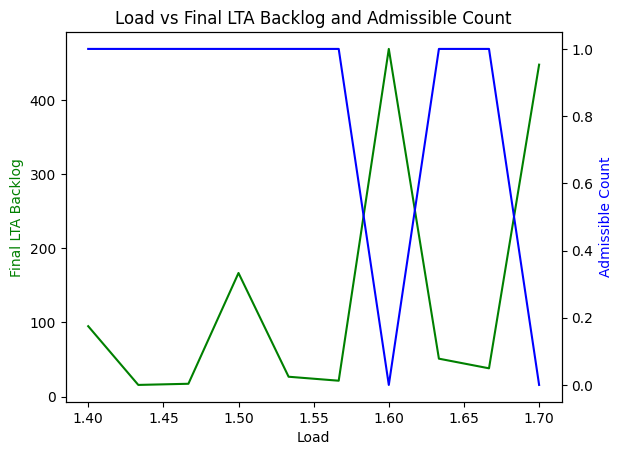

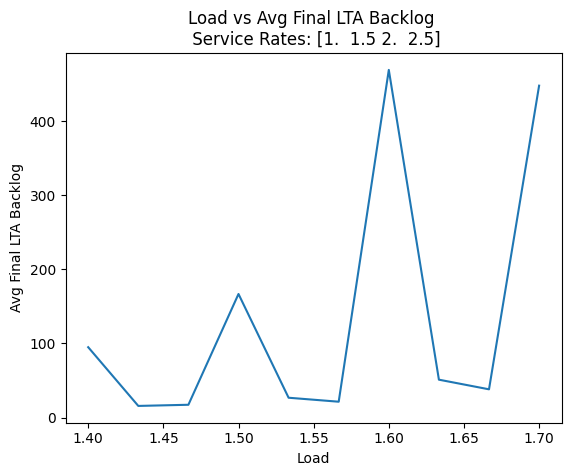

100%|██████████| 10/10 [01:26<00:00,  8.70s/it, load=1.7, trial=0]


In [3]:
load_range = np.linspace(1.4, 1.7, 10)
env_params = parse_env_json(f"{base_name}.json")
load_range, final_lta_backlogs, admissible_count =find_load_threshold(env_params, load_range, repeats = 1, seed=0)

# Sample from the Context Space

In [2]:
# Manually Select load factor based on above results
load_factor = 1.5

# Settings for the sampling loop
num_admissible_envs = 10
num_rollouts_per_env = 1
rollout_steps =  50_000
keep_dominated = False

# File Loading and Saving
base_param_file = "SH4.json"
if keep_dominated:
    save_path = f"{base_param_file.split('.')[0]}_lf{load_factor}_context_space.json"
else:
    save_path = f"{base_param_file.split('.')[0]}_lf{load_factor}_context_space-nondominated.json"
# check if save_path exists, if so, then add a number to the end of the file
if os.path.exists(save_path):
    i = 1
    while os.path.exists(f"{save_path.split('.')[1]}_{i}.json"):
        i += 1
    save_path = f"{save_path.split('.')[1]}_{i}.json"

# Sample the environment parameters
context_space_dict = sample_context_space(base_param_file,
                                       num_admissible_envs,
                                       num_rollouts_per_env,
                                       rollout_steps,
                                       keep_dominated=False,
                                       load_factor=load_factor,  #1.32
                                       terminal_backlog=1000,
                                       add_borders=True)


serial_context_dictionary = make_serializable(context_space_dict)
with open(save_path, "w") as f:
    json.dump(serial_context_dictionary, f)
print(f"Saved multi_env_params to {save_path}")

CURR_FILE_PATH: C:\Users\Jerrod\PycharmProjects\GDRL4Nets\torchrl_development\envs
TORCHRL_DEVELOPMENT_PATH: C:\Users\Jerrod\PycharmProjects\GDRL4Nets\torchrl_development
CONFIG_FILE_PATH: C:\Users\Jerrod\PycharmProjects\GDRL4Nets\torchrl_development\config\environments


Getting non-dominated (key) rates: 100%|██████████| 10/10 [08:26<00:00, 50.62s/it]   

Number of sampled environments: 10
Number of admissible rates: 10
Saved multi_env_params to SH4_lf1.5_context_space-nondominated_2.json


## Plotting information on the context space vertices

In [11]:
# Load the context space dictionary
# save_path = "SH4_lf1.5_context_space-nondominated.json"
with open(save_path, "r") as f:
    context_space_dict = json.load(f)


In [3]:
# Change settings so plots are generated a pop up window not using Qt
import matplotlib.pyplot as plt
plt.switch_backend('TkAgg')


In [4]:
ltas = context_space_dict["ltas"]
arrival_rates = np.array([context_space_dict["context_dicts"][str(i)]["arrival_rates"] for i in range(context_space_dict["num_envs"])])
network_loads = context_space_dict["network_loads"]
# plot histogram of ltas
plot_lta_histogram(ltas)
plot_arrival_rate_histogram(arrival_rates)

# Now create many samples from the context space

In [7]:
num_contexts = 50
thin = 1000
sampling_method = 'hit_and_run' #'dilkins' or 'hit_and_run'
date_time = datetime.now().strftime('%m%d%H%M')

# create folder to store all the sampled context parameters and context set dictionary
folder_name = f"{base_name}_sampled_contexts_{num_contexts}_{sampling_method}_{date_time}"
# if folder doesn't exist, create it
if not os.path.exists(folder_name):
    os.mkdir(folder_name)
param_save_file = f"{base_name}_sampled_context_parameters_{num_contexts}_{sampling_method}_{date_time}.json"
context_set_dict_file_name = f"{base_name}_context_set_{num_contexts}_{date_time}.json"
if sampling_method == 'hit_and_run':
    print("Starting Hit and Run Sampling")
    context_samples = sample_contexts_hit_and_run(context_space_dict, num_contexts, thin = thin)
else:
    context_samples = sample_contexts_dilkins(context_space_dict, num_contexts)

Starting Hit and Run Sampling


In [8]:
## Plot the histogram of the context samples
import matplotlib.pyplot as plt
# change so it plots to a white background, but I don't have seaborn-white
# print(plt.style.available)
plot_arrival_rate_histogram(context_samples, title = f"{sampling_method} Sampling Parameters Histogram")


# Create Context Set Dictionary

In [ ]:
make_env_params = {"observe_lambda": False,
                           "seed": None,
                           "terminal_backlog": None,
                           "observation_keys": ["Q", "Y"],
                           "inverse_reward": False,
                           "stat_window_size": 100000,
                           "terminate_on_convergence": False,
                           "convergence_threshold": 0.01}

context_set_dict = create_context_set_dict(context_samples,
                                                   context_space_dict["context_dicts"]["0"]["env_params"],
                                                   make_env_params)
serial_context_set_dictionary = make_serializable(context_set_dict)
with open(os.path.join(folder_name, context_set_dict_file_name), "w") as f:
     json.dump(serial_context_set_dictionary, f)

Computing LTA for sampled contexts:  48%|████▊     | 24/50 [1:05:17<1:10:05, 161.74s/it]

In [11]:
context_set_dict = json.load(open("SH3_sampled_contexts_100_dikins_03251626/SH3_context_set_100_03251626.json", "r"))
context_set_dict = json.load(open("SH2u_context_set_100_03211523.json", "r"))

In [12]:
ltas = context_set_dict["ltas"]
arrival_rates = np.array([context_set_dict["context_dicts"][str(i)]["arrival_rates"] for i in range(context_set_dict["num_envs"])])
network_loads = context_set_dict["network_loads"]
# plot histogram of ltas
plot_lta_histogram(ltas)
plot_arrival_rate_histogram(arrival_rates)